In [35]:
%load_ext autoreload
%autoreload 2


import os
import sys
import glob
import torch
import json
import pandas as pd
import time
import qgrid
import torch
import collections
import functools

from pytorch_utils.logging import LoggerReader
from pytorch_utils.collection_utils import keychain_value_iter
from collections import defaultdict, OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from millify import millify

%matplotlib inline

from nb_common import load_results, args_df_from_results, progress

DEVICE = 'cuda:2'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# root = Path('/scratch2/chofer/toporeg_sandbox/'

# root = Path('/tmp/tmp_results')
# root = Path('/tmp/testing')
# root = Path('/tmp/debug')
#root = Path('/tmp/grid_1')


# root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results')
#root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_random_label/')
# root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_noisy_label/')
#root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_noisy_label/')
root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_performance/')
#root = Path('//home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_noisy_label_zhang/')
#root = Path('/tmp/test/')



In [37]:
# args_white_list = {
#     'num_runs',
#     'num_samples',
#     'num_batches',
#     'batch_size',
#     'tag', 
#     'eval_interval',
#     'model', 
#     'lr_init',
#     'weight_decay',
#     'ds_train',
#     'ds_test' ,
#     'momentum',
#     'augment',
#     'losses',
#     'w_losses',
#     'label_noise_fraction'
# }

args_white_list = {
    'num_batches',
    'batch_size',
    'tag', 
    'weight_decay',
    'ds_train',
    'ds_test' ,
    'augment',
    'label_noise_fraction',
    'scheduler'
}

args_simple = {
    'model_comp': lambda a: a['model'][1]['compactification_cfg'][0], 
    'model_lin': lambda a: a['model'][1]['linear_cfg'][0], 
    'loss': lambda a: a['losses'][0][0],
}

# tag='spectral_norm'
tag = None


args_df_from_results = functools.partial(args_df_from_results, args_white_list=args_white_list, args_simple=args_simple)



def progress_from_results():
    RESULTS = load_results(root, tag=tag)
    
    tmp = defaultdict(list)
    
    for i, r in enumerate(RESULTS):
        
        p = progress(r)
        
        if isinstance(p, str):
            tmp['Idx'].append(i)
            tmp['progress'].append(p)
            tmp['path'].append(r.path)
            
    return pd.DataFrame(tmp)
    

def df_from_results():
    RESULTS = load_results(root, tag=tag)
    A = args_df_from_results(RESULTS)
    progress
    tmp = []
    for i, r in enumerate(RESULTS):
        df = {}
        for k in [
            'linear_train',
            'linear_test',
            'retrained_linear_train',
            'retrained_linear_test',
            'explicit_linear_train', 
            'explicit_linear_test'        
        ]:
            try:
                df[k] = np.mean([run[k][-1] for run in r])
                
            except KeyError:
                pass
            
        tmp.append(pd.DataFrame(df, index=[i]))
    
    B = pd.concat(tmp, sort=False)
    return A.join(B) 

In [1]:
def plt_losses(idx,from_batch_i=0):
    RESULTS = load_results(root)
    plt.figure() 
    
    r = RESULTS[idx][0] 
    
    for k, v in r.items():
        
        if 'batch_' in k and k not in ['batch_cls_loss', 'batch_i']:
            Y = r[k][from_batch_i:]
            X = list(range(len(Y)))
            plt.plot(X, Y, label=k.split('batch_')[1], alpha=0.5)
            
    plt.legend()
    plt.grid()
    
def plt_curves(idx, keys):
    if isinstance(keys, str):
        keys = [keys]
    RESULTS = load_results(root)
    plt.figure() 
    
    r = RESULTS[idx][0] 
    
    for k in keys:
        plt.plot(r[k], label=k)
    plt.legend()
    plt.grid()
    
def plt_loss_from_multiple_exp(idxs, loss_name, from_batch_i=0, to_batch_i=0, labeler=None, run_i=0):
    RESULTS = load_results(root)
    plt.figure() 
    
    for idx in idxs:
        
        r = RESULTS[idx]
        label = 'Idx_{}'.format(idx) if labeler is None else str(labeler(r))
        plt.plot(r[run_i][loss_name][from_batch_i:to_batch_i], label=label, linewidth=0.5)

    plt.legend()
    plt.grid()
    
    
def args_diff(idx_1, idx_2):
    R = load_results(root)
    a_1 = R[idx_1].experiment_args
    a_2 = R[idx_2].experiment_args
    
    for (k_1, v_1), (k_2, v_2) in zip(keychain_value_iter(a_1), keychain_value_iter(a_2)):
        assert k_1 == k_2 
        if v_1 != v_2:
            print(k_1, ':')            
            print('\t', idx_1, ':' , v_1)
            print('\t', idx_2, ':' , v_2)

In [56]:
progress_from_results()

,Idx,progress,path
0,48,1/1 0.34%,/home/pma/chofer/repositories/py_supcon_vs_ce/...
1,49,1/1 0.33%,/home/pma/chofer/repositories/py_supcon_vs_ce/...


In [55]:
qgrid_widget = qgrid.show_grid(df_from_results(), show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [27]:
R = load_results(root)
from nb_common import *

def get_cls_weights(path, run_i=0):
    ctx = load_experiment_context(path, run_i=run_i)    
    return ctx['model'].cls.weight.data

print(np.array(R[26][0]['batch_CrossEntropy'][-1000:]).mean())
weights = get_cls_weights(load_results(root)[26].path)
print(weights.norm(dim=1).mean(), weights.norm(dim=1).std())

0.00036865793951437807
tensor(2.0978) tensor(0.0372)


0.6285604693491893
tensor(0.0328)


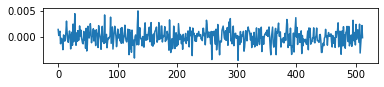

In [28]:
print(np.log(1+(10.0-1)*np.exp(-1*weights.norm(dim=1).mean().item()*10.0/(10.0-1))))
plt.figure(figsize=(6,1))
plt.plot(weights.mean(dim=0).view(-1))
print(weights.mean(dim=0).norm(p=2))

In [72]:
R = load_results(root)

R[77].experiment_args

{'output_root_dir': '/home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_noisy_label_zhang',
 'num_batches': 100000,
 'label_noise_fraction': 0.0,
 'tag': 'noisy_labels_bs512',
 'eval_interval': 500,
 'num_runs': 1,
 'num_samples': None,
 'model': ['ResNet18',
  {'compactification_cfg': ['sphere_l2', {}],
   'latent_dim': None,
   'linear_cfg': ['Linear', {'bias': False}],
   'batch_norm': True}],
 'lr_init': 0.1,
 'weight_decay': 0.0001,
 'ds_train': 'cifar100_train',
 'ds_test': 'cifar100_test',
 'momentum': 0.9,
 'augment': 'none',
 'batch_size': 512,
 'losses': [['SupConLoss', {'temperature': 0.1}]],
 'losses_track_only': [],
 'w_losses': None,
 'evaluation_policies': ['linear', 'retrained_linear', 'explicit_linear'],
 'scheduler': 'exponential',
 'experiment_type': 'core.experiment.ExpNoisyLabeledDataZhang'}

In [138]:
def print_performance_table(root, ds='cifar10_train', aug='none'):
    R = load_results(root)
    match = {'CE (Fixed)':
                {
                    'ds_train' : ds,
                    'augment'  : aug,
                    'scheduler': 'exponential',
                    'losses'   : [['CrossEntropy', {'reduction': 'mean'}]],
                    'model': ['ResNet18',
                        {
                            'compactification_cfg': ['none', {}],
                            'linear_cfg': ['FixedSphericalSimplexLinear', {}],
                            'batch_norm': True,
                            'latent_dim': None
                        }]
                },
             'CE (Vanilla)':
                {
                    'ds_train' : ds,
                    'augment'  : aug,
                    'scheduler': 'exponential',
                    'losses'   : [['CrossEntropy', {'reduction': 'mean'}]],
                    'model': ['ResNet18',
                        {
                           'compactification_cfg': ['none', {}],
                           'linear_cfg': ['Linear', {'bias': False}],
                           'batch_norm': True,
                           'latent_dim': None
                        }] 
                },
             'CE (Spherical)':
                {
                    'ds_train' : ds,
                    'augment'  : aug,
                    'scheduler': 'exponential',
                    'losses'   : [['CrossEntropy', {'reduction': 'mean'}]],
                    'model': ['ResNet18',
                        {
                           'compactification_cfg': ['sphere_l2', {}],
                           'linear_cfg': ['Linear', {'bias': False}],
                           'batch_norm': True,
                           'latent_dim': None
                        }] 
                },
             'SupCon':
                {
                    'ds_train' : ds,
                    'augment'  : aug,
                    'scheduler': 'exponential',
                    'losses': [['SupConLoss', {'temperature': 0.1}]],
                    'model': ['ResNet18',
                        {
                           'compactification_cfg': ['sphere_l2', {}],
                           'linear_cfg': ['Linear', {'bias': False}],
                           'batch_norm': True,
                           'latent_dim': None
                        }] 
                }
            }

    n_match = len(match) 

    for method, m in match.items():
        n_match = len(m)
        for r in R:
            found = 0
            for k,v in m.items():
                if r.experiment_args[k] == v:
                    found += 1 

            if found == n_match:
                print(found, r.experiment_args['batch_size'])
                print('{:15s} | {:.2f}'.format(
                    method,
                    r[0]['retrained_linear_test'][0]))
            
print_performance_table(root, ds='cifar10_train', aug='standard')

5 256
CE (Fixed)      | 93.81
5 512
CE (Fixed)      | 93.74
5 256
CE (Vanilla)    | 93.66
5 512
CE (Vanilla)    | 93.86
5 256
CE (Spherical)  | 94.26
5 512
CE (Spherical)  | 93.86
5 256
SupCon          | 94.30
5 512
SupCon          | 94.15


In [ ]:
def plt_label_noise(tag=None):
    tag = tag
    R = load_results(root, tag=tag)
#     assert len(set((r.experiment_args['num_batches'] for r in R))) == 1
#     assert len(set((r.experiment_args['eval_interval'] for r in R))) == 1
    
    eval_int = R[0].experiment_args['eval_interval']
    
    key = lambda x: x.experiment_args['label_noise_fraction']

    l_ce = sorted([r for r in R if r.experiment_args['losses'][0][0] == 'CrossEntropy'], key=key)
    l_supcon = sorted([r for r in R if r.experiment_args['losses'][0][0] == 'SupConLoss'], key=key)

    for ce, supcon in zip(l_ce, l_supcon):
        plt.figure()
        #assert key(ce) == key(supcon)
        plt.title("label_fraction  " +  str(key(ce)))
        
        
        acc = ce[0]['retrained_linear_train']
        X = [i*eval_int for i in range(len(acc))]
        plt.plot(X, acc, label='ce')
        
        acc = supcon[0]['retrained_linear_train']
        X = [i*eval_int for i in range(len(acc))]
        plt.plot(X, acc, label='supcon last={:.2f}'.format(acc[-1]))
        plt.gca().axhline(acc[-1], linestyle='--', color='gray')
        
        plt.legend()
        plt.grid()
        plt.ylim((0, 100))
        
plt_label_noise(tag='no_momentum')
# for r in sorted(tmp[k], key=lambda x: x.experiment_args[''])

# plt.plot(load_results(root, tag=tag)[idx][0]['retrained_linear_train'])
# plt.grid()
# plt.figure()
# plt.plot(np.array(load_results(root, tag=tag)[idx][0]['retrained_linear_loss']).T);


In [ ]:
def export_csv(idxs, root, loss_name):
    res = load_results(root)
    D = {}
    for i in idxs:
        col_str = '{}'.format(res[i].experiment_args['label_noise_fraction'])
        D[col_str] = res[i][0][loss_name]
    
    return D
        
to_csv = pd.DataFrame(data=export_csv([21,23,24,32],root,'batch_SupConLoss'))
to_csv.to_csv('/tmp/res.csv', index_label='batch')

In [ ]:
# plt_curves(-1, [
# #     'r_linear', 
# #     'tracked_ce_loss_spherical', 
#     'retrained_linear_loss'
# #     'batch_CrossEntropy'
# ])

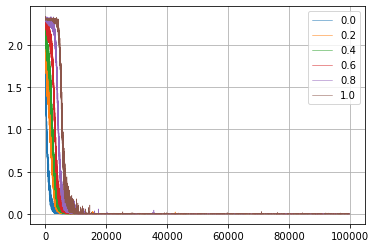

In [95]:
plt_loss_from_multiple_exp([21,25,29,33,37,41], 'batch_CrossEntropy', 
                           labeler=lambda x: x.experiment_args['label_noise_fraction'], 
                           from_batch_i=100, to_batch_i=100000)

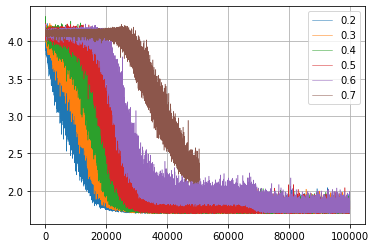

In [148]:
plt_loss_from_multiple_exp([69,71,73, 75,80,82], 
                           'batch_SupConLoss', 
                           labeler=lambda x: x.experiment_args['label_noise_fraction'], 
                           from_batch_i=0,
                           to_batch_i=100000)

In [ ]:
#plt_loss_from_multiple_exp([1], 'batch_CrossEntropy', labeler=lambda x: x.experiment_args['num_samples'], from_batch_i=100)
#plt_loss_from_multiple_exp([11, 12, 13, 14, 15], 'batch_SupConLoss', labeler=lambda x: x.experiment_args['num_samples'], from_batch_i=0)

In [ ]:
def plt_batch_size_degeneration():
    R = load_results(root)
    R = [r for r in R if r.experiment_args['tag'] == 'small_batches_degeneration']
    
    eval_policies = ['retrained_linear_train', 'retrained_linear_test', 'explicit_linear_train', 'explicit_linear_test']
    
    for aug_policy in ['none', 'supcon']:
        
        RR = [r for r in R if r.experiment_args['augment'] == aug_policy]
        RR = sorted(RR, key=lambda x: x.experiment_args['batch_size'])
        
        plt.figure()
        plt.title('Augmentation policy: ' + aug_policy)
        
        X = [r.experiment_args['batch_size'] for r in RR]
        
        for eval_p in eval_policies:
            Y = [r[0][eval_p][-1] for r in RR]
            
            plt.plot(X, Y, label=eval_p)
        
        plt.legend()
        plt.xlabel('batch size')
        plt.ylabel('accuracy')
        plt.grid()
        
plt_batch_size_degeneration()

In [ ]:
r = load_results(root)[-1]
print(r.experiment_args['losses'])
r[0]['retrained_linear_test']

In [ ]:
def plt_norms():
    R = load_results(root, tag='norms_of_w')
#     R = load_results(root)[-1:]
    
    for r in R:
        
        title = ''
        
        title += r.experiment_args['model'][1]['compactification']
        title += ', '
        title += r.experiment_args['experiment_type']
        
        
        plt.figure()
        plt.title(title)
         
        X = np.array(r[0]['norm_w']).T
        
        for x in X: 
            plt.plot(x)
        
        
    
plt_norms()

In [ ]:
def plt_trained_vanilla_ce_tracked_spherical_ce():
    R = load_results(root, tag='optimize_vanilla_ce_track_spherical_ce')
    print(len(R))
    
    
    for r in R:
        print(r.experiment_args)
        plt.figure()
        for k in ['batch_CrossEntropy', 'tracked_ce_loss_spherical']:
            plt.plot(r[0][k], label=k)
    plt.legend()

plt_trained_vanilla_ce_tracked_spherical_ce()